In [1]:
import cv2
import torch
import ipywidgets.widgets as widgets
from IPython.display import clear_output
import numpy as np
import os
import threading, queue
import pandas as pd
import time
from Arm_Lib import Arm_Device
from moves import *

Arm = Arm_Device()
time.sleep(.1)

default(Arm)
time.sleep(1)

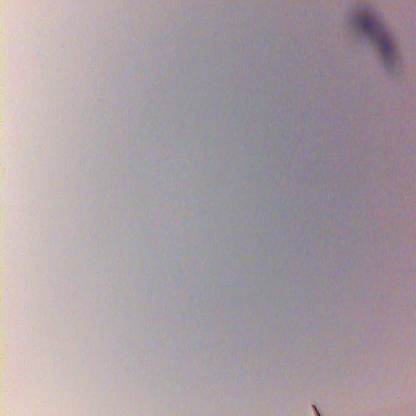

Empty DataFrame
Columns: [xmin, ymin, xmax, ymax, confidence, class, name]
Index: []


In [ ]:
model = torch.hub.load('yolov5', 'custom', path='yolov5/best.pt', source='local') 
model.cpu()

mode_int = 0

mode_table = {'battery': ['metal', 'very_dangerous'],
              'knife': ['plastic', 'dangerous'],
              'lamp': ['glass', 'dangerous'],
              'napkin': ['paper', 'safe'],
              'peel': ['organic', 'safe'],
              'plastic_bottle': ['plastic', 'dangerous'],
              'poly_bag': ['plastic', 'dangerous'],
              'sigarette': ['paper', 'safe'],
              'tetrapack': ['tetrapack', 'safe'],
              'can': ['metal', 'dangerous'],
              'cap': ['plastic', 'dangerous'],
              'cup': ['plastic', 'dangerous'],
              'fork': ['plastic', 'dangerous'],
              'glass_bottle': ['glass', 'safe'],
              'yogurt': ['plastic', 'dangerous']
             }

class_table ={'safe': 180,
              'dangerous': 0,
              'very_dangerous': 45,
              'metal': 45,
              'paper': 0,
              'organic': 160,
              'plastic': 180,
              'glass': 135,
              'tetrapack': 10-40}

class VideoCapture:
  def __init__(self, name):
    self.cap = cv2.VideoCapture(name)
    self.q = queue.Queue()
    t = threading.Thread(target=self._reader)
    t.daemon = True
    t.start()

  def _reader(self):
    while True:
      ret, frame = self.cap.read()
      if not ret:
        break
      if not self.q.empty():
        try:
          self.q.get_nowait()
        except queue.Empty:
          pass
      self.q.put(frame)

  def read(self):
    return self.q.get()

cap = VideoCapture(-1)

def main():
    global mode_int
    while True:
        frame = cap.read()
        RGB_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(RGB_img, (416, 416))
        clear_output(wait=True)
        outputs = model(frame)
        outputs.show()
        predicts = outputs.pandas().xyxy[0]
        hand_filt = (predicts['name'] == 'hand') | (predicts['name'] == 'thumbs_up') \
                | (predicts['name'] == 'one_finger') | (predicts['name'] == 'two_fingers')
        temp_res = predicts[hand_filt]
        max_conf_filt = (temp_res['confidence'] == temp_res['confidence'].max())
        temp_res = temp_res[max_conf_filt]
        try:
            hand_comm = temp_res.iloc[0]['name']
            if(hand_comm == "one_finger" and mode_int == 1):
                nod(1, Arm)
                mode_int = 0
            if(hand_comm == "two_fingers" and mode_int == 0):
                nod(2, Arm)
                mode_int = 1
            continue
        except IndexError:
            pass
        trash_filt = (predicts['name'].isin(list(mode_table.keys())))
        temp_res = predicts[trash_filt]
        max_conf_filt = (temp_res['confidence'] == temp_res['confidence'].max())
        temp_res = temp_res[max_conf_filt]
        try:
            min_x_val = temp_res.iloc[0]['xmin']
            max_x_val = temp_res.iloc[0]['xmax']
            hand_comm = temp_res.iloc[0]['name']
            end_angl = 120 - ((max_x_val + min_x_val)/(2*416))*60
            grab(Arm, class_table.get(mode_table.get(hand_comm)[mode_int]), end_angl)
        except IndexError:
            pass
        try:
            print(outputs.pandas().xyxy[0])
            print(temp_res.iloc[0]['xmin'], temp_res.iloc[0]['xmax'])
        except IndexError:
            pass
try :
    main()
    
except KeyboardInterrupt:
    print(" Program closed! ")
    pass